Disciplina: Aprendizagem de Máquina

Período: 2025.1

Professor: César Lincoln Cavalcante Mattos

Aluno: Davi Teixeira Silva

# Lista 3 - KNN e árvores de decisão

## Questão 1

Considere o conjunto de dados disponível em kc2.csv, organizado em 22 colunas, sendo as 21 primeiras colunas os atributos e a última coluna a saída. Os 21 atributos são referentes à caracterização de códigos-fontes para processamento de dados na NASA. A saída é a indicação de ausência (0) ou existência (1) de defeitos (os dados foram balanceados via subamostragem). Maiores detalhes sobre os dados podem ser conferidos em https://www.openml.org/search?type=data&sort=runs&id=1063&status=active.

a) Considerando uma validação cruzada em 10 folds, avalie modelos de classificação binária nos dados em questão. Para tanto, use as abordagens abaixo:

- KNN (escolha k = 1 e k = 5, distância Euclidiana e Mahalonobis, totalizando 4 combinações);
- Árvore de decisão (você pode usar uma implementação já existente, como a do scikit-learn, com índices de impureza de gini e entropia).

b) Para cada modelo criado, reporte valor médio e desvio padrão das métricas de acurácia, revocação, precisão e F1-score.

In [5]:
import numpy as np

# Carregar os dados do arquivo
data = np.genfromtxt('kc2.csv', delimiter=',')

# Separar atributos (X) e rótulo (y)
X = data[:, :-1]  # 21 colunas de atributos
y = data[:, -1]   # Última coluna: rótulo (0 ou 1)

# Normalização Z-score: (x - média) / desvio padrão
def z_score_normalize(X):
  mean = X.mean(axis=0)
  std = X.std(axis=0)
  return (X - mean) / std

X_normalized = z_score_normalize(X)

# Divisão em k-fold
def k_fold_split(X, y, k=10, seed=42):
  np.random.seed(seed)
  indices = np.arange(len(X))
  np.random.shuffle(indices)

  fold_size = len(X) // k
  folds = []

  for i in range(k):
    start = i * fold_size
    end = start + fold_size if i != k - 1 else len(X)

    test_idx = indices[start:end]
    train_idx = np.concatenate((indices[:start], indices[end:]))

    folds.append((train_idx, test_idx))

  return folds

# Métricas de distância

# Distância Euclidiana
def euclidean_distance(x1, x2):
  return np.sqrt(np.sum((x1 - x2) ** 2))

# Distância Mahalanobis
def mahalanobis_distance(x1, x2, inv_cov):
  diff = x1 - x2
  return np.sqrt(diff.T @ inv_cov @ diff)

# Previsão com KNN
def knn_predict(X_train, y_train, x_test, k=3, distance='euclidean', inv_cov=None):
  distances = []

  for i in range(len(X_train)):
    if distance == 'euclidean':
      d = euclidean_distance(x_test, X_train[i])
    elif distance == 'mahalanobis':
      d = mahalanobis_distance(x_test, X_train[i], inv_cov)
    else:
      raise ValueError("Distância não suportada")
    distances.append((d, y_train[i]))

  # Ordenar pela menor distância
  distances.sort(key=lambda tup: tup[0])

  # Obter os k vizinhos mais próximos
  neighbors = distances[:k]

  # Votação majoritária
  classes = [label for _, label in neighbors]
  prediction = max(set(classes), key=classes.count)
  return prediction

# Métricas de avaliação
def accuracy(y_true, y_pred):
  return np.mean(y_true == y_pred)

def precision(y_true, y_pred):
  tp = np.sum((y_true == 1) & (y_pred == 1))
  fp = np.sum((y_true == 0) & (y_pred == 1))
  return tp / (tp + fp) if tp + fp > 0 else 0

def recall(y_true, y_pred):
  tp = np.sum((y_true == 1) & (y_pred == 1))
  fn = np.sum((y_true == 1) & (y_pred == 0))
  return tp / (tp + fn) if tp + fn > 0 else 0

def f1_score(y_true, y_pred):
  p = precision(y_true, y_pred)
  r = recall(y_true, y_pred)
  return 2 * p * r / (p + r) if p + r > 0 else 0

# Avaliação com validação cruzada para KNN
def evaluate_knn_cv(X, y, k=3, distance='euclidean'):
  folds = k_fold_split(X, y, k=10)
  accs, precs, recalls, f1s = [], [], [], []

  for train_idx, test_idx in folds:
    X_train, y_train = X[train_idx], y[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]

    # Calcular a matriz de covariância e inversa se for Mahalanobis
    inv_cov = None
    if distance == 'mahalanobis':
      cov = np.cov(X_train, rowvar=False)
      try:
        inv_cov = np.linalg.inv(cov)
      except np.linalg.LinAlgError:
        print("A matriz de covariância é singular. Usando pseudo-inversa.")
        inv_cov = np.linalg.pinv(cov)

    # Prever todos os dados de teste
    y_pred = np.array([
      knn_predict(X_train, y_train, x, k=k, distance=distance, inv_cov=inv_cov)
      for x in X_test
    ])

    # Calcular métricas
    accs.append(accuracy(y_test, y_pred))
    precs.append(precision(y_test, y_pred))
    recalls.append(recall(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred))

  return {
    'accuracy': (np.mean(accs), np.std(accs)),
    'precision': (np.mean(precs), np.std(precs)),
    'recall': (np.mean(recalls), np.std(recalls)),
    'f1_score': (np.mean(f1s), np.std(f1s))
  }

In [6]:
# Funções de impureza para árvore de decisão
def gini(y):
  classes = np.unique(y)
  impurity = 1
  for cls in classes:
    p = np.sum(y == cls) / len(y)
    impurity -= p ** 2
  return impurity

def entropy(y):
  classes = np.unique(y)
  entropy = 0
  for cls in classes:
    p = np.sum(y == cls) / len(y)
    if p > 0:
      entropy -= p * np.log2(p)
  return entropy

# Encontrar o melhor split
def best_split(X, y, criterion='gini'):
  best_attr, best_thresh, best_gain = None, None, -np.inf
  n_samples, n_features = X.shape

  impurity_func = gini if criterion == 'gini' else entropy
  parent_impurity = impurity_func(y)

  for feature in range(n_features):
    thresholds = np.unique(X[:, feature])
    for thresh in thresholds:
      left_mask = X[:, feature] <= thresh
      right_mask = ~left_mask

      if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
        continue

      y_left, y_right = y[left_mask], y[right_mask]
      left_impurity = impurity_func(y_left)
      right_impurity = impurity_func(y_right)

      n_left, n_right = len(y_left), len(y_right)
      weighted_impurity = (n_left * left_impurity + n_right * right_impurity) / n_samples

      gain = parent_impurity - weighted_impurity
      if gain > best_gain:
        best_gain = gain
        best_attr = feature
        best_thresh = thresh

  return best_attr, best_thresh

# Construindo a árvore
class Node:
  def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
    self.feature = feature
    self.threshold = threshold
    self.left = left
    self.right = right
    self.value = value

def build_tree(X, y, depth=0, max_depth=None, criterion='gini'):
  # Parada: todos iguais ou sem mais atributos
  if len(set(y)) == 1 or len(y) == 0:
    return Node(value=int(np.round(np.mean(y))))

  attr, thresh = best_split(X, y, criterion)

  if attr is None:
    return Node(value=int(np.round(np.mean(y))))

  left_mask = X[:, attr] <= thresh
  right_mask = ~left_mask

  left_node = build_tree(X[left_mask], y[left_mask], depth + 1, max_depth, criterion)
  right_node = build_tree(X[right_mask], y[right_mask], depth + 1, max_depth, criterion)

  return Node(feature=attr, threshold=thresh, left=left_node, right=right_node)

# Predição com a árvore
def predict_tree(node, x):
  while node.value is None:
    if x[node.feature] <= node.threshold:
      node = node.left
    else:
      node = node.right
  return node.value

# Avaliação com validação cruzada para Árvore de Decisão
def evaluate_tree_cv(X, y, criterion='gini'):
  folds = k_fold_split(X, y, k=10)
  accs, precs, recalls, f1s = [], [], [], []

  for train_idx, test_idx in folds:
    X_train, y_train = X[train_idx], y[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]

    root = build_tree(X_train, y_train, criterion=criterion)
    y_pred = np.array([predict_tree(root, x) for x in X_test])

    accs.append(accuracy(y_test, y_pred))
    precs.append(precision(y_test, y_pred))
    recalls.append(recall(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred))

  return {
    'accuracy': (np.mean(accs), np.std(accs)),
    'precision': (np.mean(precs), np.std(precs)),
    'recall': (np.mean(recalls), np.std(recalls)),
    'f1_score': (np.mean(f1s), np.std(f1s))
  }


KNN k=1 (euclidean)
accuracy: média = 0.7648, desvio = 0.1256
precision: média = 0.7951, desvio = 0.1551
recall: média = 0.7565, desvio = 0.1545
f1_score: média = 0.7629, desvio = 0.1161

KNN k=5 (euclidean)
accuracy: média = 0.7728, desvio = 0.1246
precision: média = 0.7805, desvio = 0.1327
recall: média = 0.7636, desvio = 0.1650
f1_score: média = 0.7654, desvio = 0.1292

KNN k=1 (mahalanobis)
accuracy: média = 0.6966, desvio = 0.1128
precision: média = 0.7318, desvio = 0.1427
recall: média = 0.6438, desvio = 0.1349
f1_score: média = 0.6766, desvio = 0.1139

KNN k=5 (mahalanobis)
accuracy: média = 0.7594, desvio = 0.1055
precision: média = 0.8075, desvio = 0.1003
recall: média = 0.6858, desvio = 0.1354
f1_score: média = 0.7367, desvio = 0.1156

Decision Tree (gini)
accuracy: média = 0.6823, desvio = 0.1107
precision: média = 0.7073, desvio = 0.1515
recall: média = 0.6594, desvio = 0.1170
f1_score: média = 0.6736, desvio = 0.1031

Decision Tree (entropy)
accuracy: média = 0.6981, desv

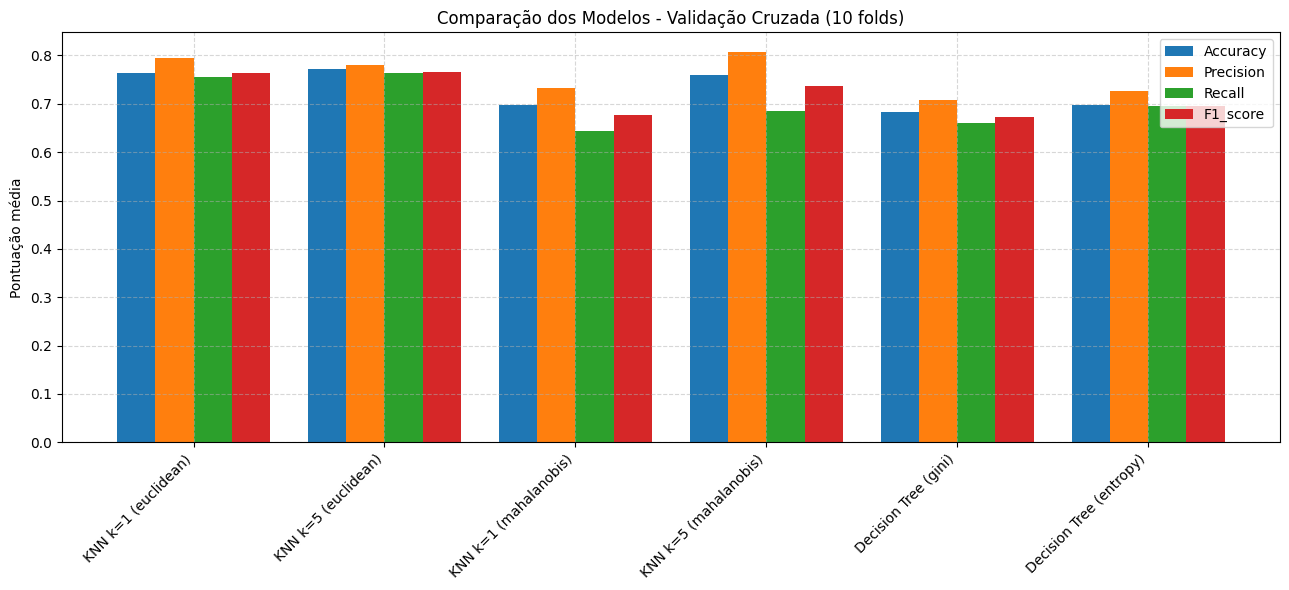

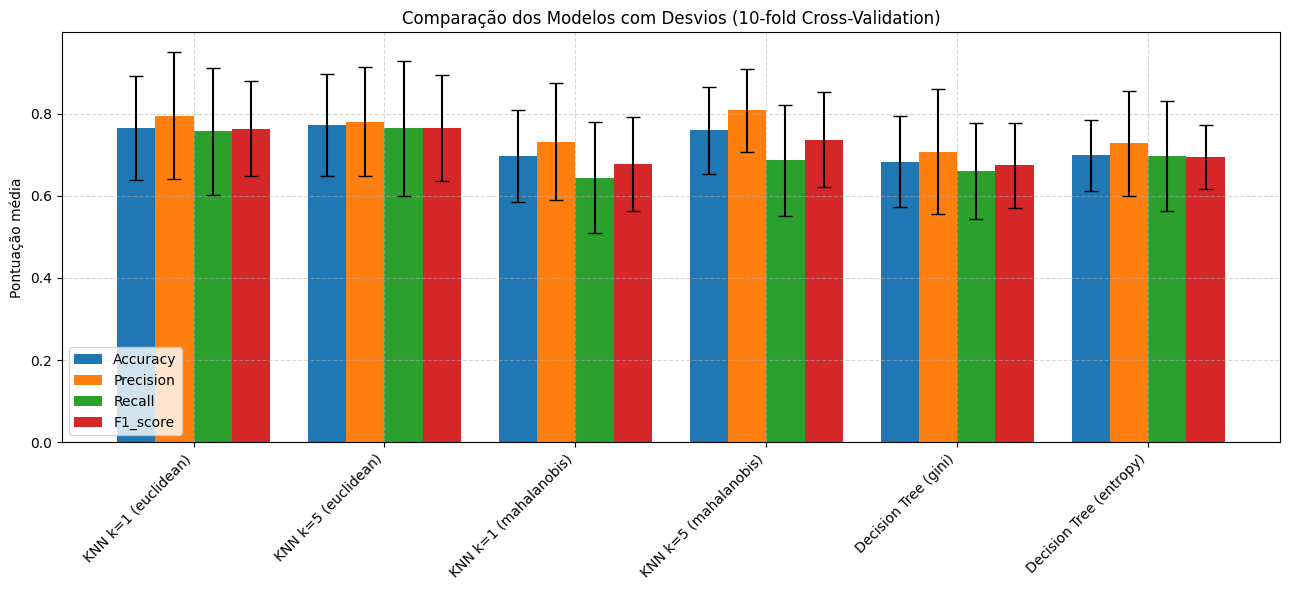


Qual modelo teve melhor desempenho em cada métrica:

Melhor accuracy: KNN k=5 (euclidean) com média de 0.7728
Melhor precision: KNN k=5 (mahalanobis) com média de 0.8075
Melhor recall: KNN k=5 (euclidean) com média de 0.7636
Melhor f1_score: KNN k=5 (euclidean) com média de 0.7654


In [10]:
import matplotlib.pyplot as plt

# Executar experimentos e armazenar resultados automaticamente
results = {}

# KNN
combinacoes = [(1, 'euclidean'), (5, 'euclidean'), (1, 'mahalanobis'), (5, 'mahalanobis')]
for k, dist in combinacoes:
  nome_modelo = f"KNN k={k} ({dist})"
  resultados = evaluate_knn_cv(X_normalized, y, k=k, distance=dist)
  results[nome_modelo] = resultados

# Árvores de Decisão
criterios = ['gini', 'entropy']
for criterio in criterios:
  nome_modelo = f"Decision Tree ({criterio})"
  resultados = evaluate_tree_cv(X_normalized, y, criterion=criterio)
  results[nome_modelo] = resultados

# Exibir resultados
for modelo, metricas in results.items():
  print(f"\n{modelo}")
  for metrica, (media, desvio) in metricas.items():
    print(f"{metrica}: média = {media:.4f}, desvio = {desvio:.4f}")

# Função para plotar comparação sem barras de erro
def plot_model_comparison(results):
  labels = list(results.keys())
  metrics = ['accuracy', 'precision', 'recall', 'f1_score']

  x = np.arange(len(labels))  # posições no eixo x
  width = 0.2

  fig, ax = plt.subplots(figsize=(13, 6))

  for i, metric in enumerate(metrics):
    metric_means = [results[model][metric][0] for model in labels]
    ax.bar(x + i*width - 1.5*width, metric_means, width, label=metric.capitalize())

  ax.set_ylabel('Pontuação média')
  ax.set_title('Comparação dos Modelos - Validação Cruzada (10 folds)')
  ax.set_xticks(x)
  ax.set_xticklabels(labels, rotation=45, ha='right')
  ax.legend()
  ax.grid(True, linestyle='--', alpha=0.5)

  plt.tight_layout()
  plt.show()

# Função para plotar comparação com barras de erro
def plot_model_comparison_with_error(results):
  labels = list(results.keys())
  metrics = ['accuracy', 'precision', 'recall', 'f1_score']
  colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

  x = np.arange(len(labels))
  width = 0.2

  fig, ax = plt.subplots(figsize=(13, 6))

  for i, metric in enumerate(metrics):
    means = [results[model][metric][0] for model in labels]
    stds  = [results[model][metric][1] for model in labels]
    ax.bar(x + i*width - 1.5*width, means, width, yerr=stds, capsize=5, label=metric.capitalize(), color=colors[i])

  ax.set_ylabel('Pontuação média')
  ax.set_title('Comparação dos Modelos com Desvios (10-fold Cross-Validation)')
  ax.set_xticks(x)
  ax.set_xticklabels(labels, rotation=45, ha='right')
  ax.legend()
  ax.grid(True, linestyle='--', alpha=0.5)

  plt.tight_layout()
  plt.show()

print(f"\n")
# Gerar gráficos
plot_model_comparison(results)

plot_model_comparison_with_error(results)

# Mostrar melhor modelo em cada métrica
print(f"\nQual modelo teve melhor desempenho em cada métrica:\n")
for metric in ['accuracy', 'precision', 'recall', 'f1_score']:
  best_model = max(results.items(), key=lambda x: x[1][metric][0])
  print(f'Melhor {metric}: {best_model[0]} com média de {best_model[1][metric][0]:.4f}')


## Conclusão

Neste trabalho, eu testei alguns modelos de classificação para tentar prever defeitos no conjunto de dados KC2. Usei KNN com k igual a 1 e 5, tanto com distância Euclidiana quanto Mahalanobis, além de árvores de decisão com critério Gini e entropia. Em cada caso, fiz uma validação cruzada de 10 folds para ter uma ideia de como os resultados variavam.

De forma geral, percebi que aumentar o k de 1 para 5 no KNN deixou o resultado um pouco mais estável. Por exemplo, com distância Euclidiana e k=5, a acurácia ficou em torno de 77% e o F1‐score em 76%, valores um pouco melhores do que com k=1. Já quando usei a distância Mahalanobis, o k=5 também ajudou a aumentar a precisão (chegou a 81%), mas o recall acabou ficando um pouco mais baixo. Isso significa que, se o objetivo for reduzir ao máximo falsos positivos, KNN k=5 com Mahalanobis pode ser uma boa, mas, se eu quiser que o equilíbrio entre precisão e recall seja melhor, o KNN k=5 com Euclidiana se saiu mais equilibrado.

As árvores de decisão, por sua vez, não chegaram a bater nenhum dos KNN. Elas tiveram acurácia e F1‐score menores, mesmo usando entropia, que mostrou menos variação. Acho que a árvore simples que construí acabou não capturando bem toda a complexidade dos dados, enquanto o KNN funcionou melhor para este caso.